# Extract raster coordinates

In this Notebook we are going to extract not only the elevation but also the **coordinates** of several points randomly selected over a digital elevation model (DEM)

<img src="util/raster_DEM_UTM_coord.png" style="width: 600px">

## **Steps**
### 0. Import the necessary libraries

In [23]:
# Import libraries
import numpy as np  # Import the NumPy library for numerical operations, particularly for arrays.
import rasterio  # Import the rasterio library for reading and writing geospatial raster data (like GeoTIFFs).
import matplotlib.pyplot as plt  # Import matplotlib's pyplot module for creating plots and visualizations.

### 1. Load the DEM Raster  
When you load a raster file (like a DEM) using Rasterio in Python, you get more than just the raw elevation data. Here's a breakdown of what you get:

a. **DEM (Digital Elevation Model)**

This is the core data – a 2D array (or sometimes a multi-dimensional array for multi-band rasters) of elevation values. Each cell in the array corresponds to a location on the ground, and the value in that cell represents the elevation at that point.   

In [24]:
# Open the Digital Elevation Model (DEM) raster file
raster = rasterio.open('datos/dem.tif')

# Read the first band of the DEM (assuming it's a single-band raster)
dem = raster.read(1)  # Extracts a 2D array representing elevation values

# Get the number of rows and columns in the DEM
nrows, ncols = dem.shape

b. **Metadata**

Think of metadata as the descriptive information about your DEM. This can include:
- Spatial Reference System (SRS): Tells you how the DEM is georeferenced (e.g., latitude/longitude, UTM). This is crucial for knowing where your data is located on Earth.
- Data Type: The type of data used to store elevation values (e.g., integers, floating-point numbers). This affects precision and storage size.
- NoData Values: Values used to represent areas where elevation data is missing or invalid.   
- Number of Rows and Columns: The dimensions of the DEM grid.
- Units: The units of measurement for elevation (e.g., meters, feet).
- Creation Date: When the DEM was created or last modified.
- Source: Where the DEM data came from.

In [25]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -32767.0,
 'width': 286,
 'height': 161,
 'count': 1,
 'crs': CRS.from_epsg(25830),
 'transform': Affine(5.0, 0.0, 409412.5,
        0.0, -5.0, 4132972.5)}

c. **Transform**

The transform (often called an affine transform) is a mathematical function that links the pixel coordinates in your DEM array to real-world coordinates in your chosen Spatial Reference System.
It essentially tells you how to go from a pixel in your array to a specific location on the ground (and vice versa).
The transform is usually represented as a 3x3 matrix, but Rasterio provides tools to work with it more easily.

**Why are Metadata and Transform Important?** Without metadata and the transform, your DEM is just a grid of numbers. You wouldn't know where those numbers correspond to on the Earth's surface.

In [26]:
raster.transform

Affine(5.0, 0.0, 409412.5,
       0.0, -5.0, 4132972.5)

### 2. Generate Random Points  
   - The shape of the DEM is obtained (`nrows, ncols`).
   - A total of `30` random points are generated within the raster’s row and column limits using `np.random.randint()`.

In [20]:
# Define the number of points to extract
n_points = 30

# Generate random row and column indices within the DEM dimensions
np.random.seed(42) # Set a random seed for reproducibility
row_ids = np.random.randint(0, nrows, n_points) # generate random integer values
col_ids = np.random.randint(0, ncols, n_points) # generate random integer values

### 3. Extract Elevation Values
   - Using the randomly generated coordinates, elevation values are retrieved from the `dem` array.

In [33]:
# Extract elevation values at the randomly selected points
elevations = dem[row_ids, col_ids]
print(elevations)

[825.743 817.664 755.517 743.4   856.195 831.165 805.35  737.144 816.88
 843.456 765.285 744.507 836.842 792.865 741.74  750.08  855.356 744.759
 837.281 752.888 747.851 739.659 753.518 753.572 861.193 805.976 842.264
 745.268 831.16  800.184]


### 4. Extract the UTM coordinates
To transform the `row_coords` and `col_coords` into UTM latitude and longitude values, you can use the raster's transformation matrix. Rasterio provides a `transform` attribute. This allows you to map row and column coordinates (which correspond to pixel positions in the raster) into geospatial coordinates (latitude and longitude).

The general formula to convert row and column indices into geographic UTM coordinates is:

$
\text{longitude} = \text{transform}[0] \times \text{col} + \text{transform}[2]
$

$
\text{latitude} = \text{transform}[4] \times \text{row} + \text{transform}[5]
$

- `transform[0]` corresponds to the pixel width in geographic coordinates (longitude), and `transform[2]` is the longitude of the upper-left corner of the raster.
- `transform[4]` corresponds to the pixel height (negative value for north-to-south coordinate systems), and `transform[5]` is the latitude of the upper-left corner of the raster.

In [34]:
transform = raster.transform

# Convert row/col coordinates to latitude/longitude using the affine transform
lats, lons = [], []
for i in range(n_points):
    lon = transform[0] * col_ids[i] + transform[2]
    lat = transform[4] * row_ids[i] + transform[5]
    lats.append(lat)
    lons.append(lon)
print(lats)
print(lons)

[4132462.5, 4132512.5, 4132902.5, 4132442.5, 4132617.5, 4132872.5, 4132462.5, 4132367.5, 4132602.5, 4132537.5, 4132392.5, 4132477.5, 4132457.5, 4132217.5, 4132322.5, 4132227.5, 4132712.5, 4132967.5, 4132537.5, 4132187.5, 4132787.5, 4132327.5, 4132872.5, 4132172.5, 4132687.5, 4132867.5, 4132532.5, 4132732.5, 4132682.5, 4132902.5]
[410357.5, 410282.5, 409662.5, 409682.5, 410627.5, 410062.5, 410082.5, 409512.5, 410242.5, 410777.5, 409852.5, 409477.5, 410617.5, 410732.5, 409672.5, 409867.5, 410727.5, 409582.5, 410437.5, 409812.5, 409657.5, 409417.5, 409677.5, 409937.5, 410707.5, 410362.5, 410497.5, 409627.5, 410217.5, 410417.5]


### 5. Plot the DEM and Sample Points
   - The DEM is displayed using a terrain colormap (`cmap='terrain'`).
   - The extracted elevation points are overlaid on the DEM using `plt.scatter()`, with colors representing their elevation values.
   - A color bar, legend, and title are added for clarity.

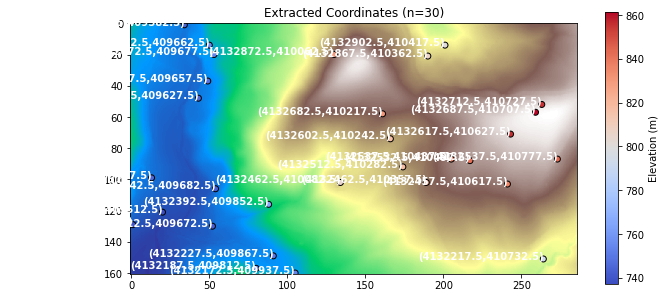

In [37]:
# Plot DEM with extracted points
plt.figure(figsize=(10, 5))
plt.imshow(dem, cmap='terrain', origin='upper')
plt.scatter(col_ids, row_ids, c=elevations, edgecolor='k', cmap='coolwarm', label='Sample Points')
plt.colorbar(label='Elevation (m)')
plt.title(f'Extracted Coordinates (n={n_points})')

# Add labels for each point
for i in range(n_points):
    plt.text(col_ids[i], row_ids[i], '('+str(lats[i])+','+str(lons[i])+')', 
             fontsize=10, ha='right', color='white', weight='bold')
    
plt.show()

### 6. Save the results
Now, let's **save** the elevation values as a text file, in this case as 'comma-separated values' (**.csv**) file. For this purpose we can use Numpy

In [115]:
# Stack them column-wise
np.savetxt('lat_lon_elev.csv', (lats, lons, elevations))

Let's make some improvements

In [114]:
# Stack them column-wise
data = np.column_stack((lats, lons, elevations))
np.savetxt('lat_lon_elev.csv', data, header="lat,lon,elev",delimiter = ',')

Or even better, let's use the library **Pandas** and save it as an Excel file

In [42]:
import pandas as pd
df = pd.DataFrame(lats, columns = ['lat'])
df.head()

,lat
0,4132462.5
1,4132512.5
2,4132902.5
3,4132442.5
4,4132617.5


In [43]:
# Let's add two more columns, one for the longitude values and another one for the elevation values
df['lon'] = lons
df['elev'] = elevations
df.head()

,lat,lon,elev
0,4132462.5,410357.5,825.742981
1,4132512.5,410282.5,817.664001
2,4132902.5,409662.5,755.517029
3,4132442.5,409682.5,743.400024
4,4132617.5,410627.5,856.195007


Let's save the dataframe as an **Excel file** (.xlsx)

In [153]:
df.to_excel('lat_lon_elev.xlsx')